In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

import matplotlib.pyplot as plt
sns.set_context('notebook')

# Yummly Dataset

Objective: predict the cuisine based on the list of ingredients.

Learning Goal: apply the techniques learned from the previous Titanic exercise with the addition of working with text data, apply dimensionality reduction techniques.

## Read in the data.

In [2]:
df_train_0 = pd.read_json('data/train.json')
df_test_0 = pd.read_json('data/test.json')

display(df_train_0.head())

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
np.shape(df_train_0)

(39774, 3)

Check for any nulls.

In [4]:
print(df_train_0.isnull().sum())
print(df_test_0.isnull().sum())

df_train = df_train_0.copy()
df_test = df_test_0.copy()

cuisine        0
id             0
ingredients    0
dtype: int64
id             0
ingredients    0
dtype: int64


How many ingredients are there for each recipe?

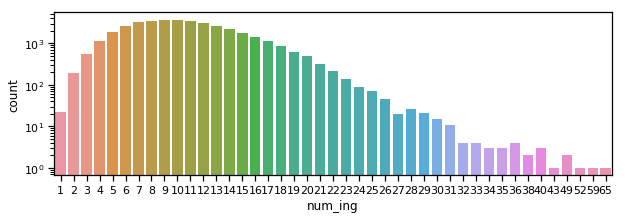

In [5]:
df_train['num_ing'] = df_train['ingredients'].apply(lambda x: len(x))
plt.figure(1, figsize=(10,3))
s = sns.countplot(x='num_ing', data=df_train)
s.set_yscale('log')

It's weird that there are single ingredient "recipes" but they still contain useful information about each cuisine.

In [6]:
display(df_train.loc[df_train.num_ing < 2])

,cuisine,id,ingredients,num_ing
940,japanese,4734,[sushi rice],1
2088,vietnamese,7833,[dried rice noodles],1
6787,indian,36818,[plain low-fat yogurt],1
7011,indian,19772,[unsalted butter],1
8181,japanese,16116,[udon],1
8852,thai,29738,[sticky rice],1
8990,indian,41124,[butter],1
10506,mexican,32631,[corn tortillas],1
13178,thai,29570,[grained],1
17804,southern_us,29849,[lemonade concentrate],1


What's the recipe with >60 ingredients?!

In [7]:
display(df_train.loc[df_train.num_ing > 60])

,cuisine,id,ingredients,num_ing
15289,italian,3885,"[fettucine, fresh marjoram, minced garlic, oli...",65


In [8]:
gtr_60_ind = df_train[df_train['num_ing'] > 60].index.values
print(df_train.ingredients[gtr_60_ind].tolist())

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pepper', 'grated parmesan cheese', 'boneless skinless chicken breasts',

This seems like a totally weird recipe. It calls for 'boneless skinless chicken breast halves', 'cooekd chicken', 'chicken cutlets', and 'boneless skinless chicken breasts.' Here's another recipe with suspiciously high number of ingredients, and an even more suspicious ingredient list.

In [9]:
display(df_train.loc[df_train.num_ing > 40])
print(df_train.ingredients[26103])

,cuisine,id,ingredients,num_ing
10513,mexican,49282,"[condensed cream of chicken soup, pepper, refr...",49
15289,italian,3885,"[fettucine, fresh marjoram, minced garlic, oli...",65
22906,indian,2253,"[white vinegar, sparkling lemonade, coconut su...",49
26103,mexican,13049,"[vanilla ice cream, lime, garlic powder, zucch...",52
30350,brazilian,13430,"[marshmallows, fresh corn, cheddar cheese, shr...",59
31250,italian,29216,"[eggs, warm water, pepper, dried basil, unsalt...",43


['vanilla ice cream', 'lime', 'garlic powder', 'zucchini', 'guacamole', 'chili powder', 'red wine vinegar', 'paprika', 'purple onion', 'yellow onion', 'fresh parsley leaves', 'fresh mint', 'cumin', 'eggs', 'black beans', 'honey', 'asparagus', 'sugar cookie dough', 'boneless skinless chicken breasts', 'zesty italian dressing', 'red pepper flakes', 'crushed red pepper flakes', 'cilantro leaves', 'cayenne pepper', 'fudge brownie mix', 'corn tortillas', 'avocado', 'black pepper', 'chocolate chip cookie mix', 'ground pepper', 'Sriracha', 'condiments', 'onion powder', 'butter', 'cilantro', 'salt', 'flat iron steaks', 'lemon juice', 'sour cream', 'green bell pepper', 'kosher salt', 'olive oil', 'pepper jack', 'jalapeno chilies', 'flank steak', 'vegetable oil', 'portabello mushroom', 'yellow bell pepper', 'salsa', 'garlic cloves', 'red bell pepper', 'candy']


Based on the distribution of number of ingredients, let's make a cut on rows with number of ingredients > 31. For every number of ingredients exceeding 31, there are fewer than 10 recipes each, so we're throwing out fewer than ~100 rows out of close to 40000 rows. We want to be conservative with these cut because we don't want to bias against cuisines that use a lot of ingredients.

In [10]:
df_train = df_train[df_train['num_ing'] < 32]

Now, moving on to the cuisines themselves: italian and Mexican cuisines are the top two popular categories. There's moderate class imbalance.

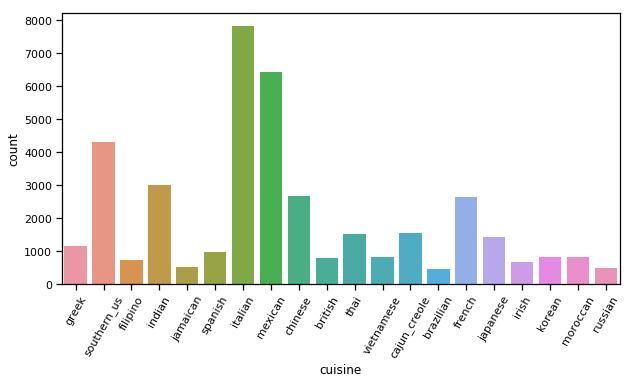

In [11]:
plt.figure(1, figsize=(10,5))
s = sns.countplot(x='cuisine', data=df_train)
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=60)

Create a new column that creates a single concatenated string out of the list of ingredients. Use a comma instead of whitespace to avoid confusion, since whitespaces appear in some ingredient names. Also turn everything into lower case.

In [12]:
df_train['ingredients_concat'] = df_train['ingredients'].apply(','.join).str.lower()
df_test['ingredients_concat'] = df_test['ingredients'].apply(','.join).str.lower()

Get the simple counts of words from the ingredients, which creates a sparse matrix.

In [13]:
count_vect = CountVectorizer(tokenizer=lambda x: [a.strip() for a in x.split(',')])
X_train_counts = count_vect.fit_transform(df_train.ingredients_concat)
print('A total of', X_train_counts.shape[0], 'recipes')
print('A total of', X_train_counts.shape[1], 'unique ingredient words')

A total of 39745 recipes
A total of 6704 unique ingredient words


A quick check shows that there are redundancies, such as "cabbage" and "cabbage leaves," which are really not unique words. Still need to figure out how to combat this issue, which might also help with decreasing= the number of features.

In [14]:
ingredient_names = np.array(count_vect.get_feature_names())
print(ingredient_names[810:815])

['cabbage' 'cabbage head' 'cabbage leaves' 'cabbage lettuce' 'cabernet']


Some of the most common ingredients include things like salt, onions, olive oil, and water. Note that garlic and garlic cloves appear separately.

In [15]:
ingredient_counts = dict(zip(ingredient_names, X_train_counts.sum(axis=0).tolist()[0]))
ingredient_counts = pd.DataFrame(list(ingredient_counts.items()), columns=['ingredients', 'counts'])
ingredient_counts['counts_frac'] = ingredient_counts['counts'].apply(lambda x: x/X_train_counts.shape[0])

In [16]:
ingredient_counts.sort_values(by='counts', ascending=False).head(n=10)

,ingredients,counts,counts_frac
5211,salt,18025,0.453516
4213,onions,7960,0.200277
4195,olive oil,7959,0.200252
6412,water,7438,0.187143
2523,garlic,7363,0.185256
5824,sugar,6425,0.161656
2529,garlic cloves,6227,0.156674
779,butter,4841,0.121801
2790,ground black pepper,4777,0.120191
79,all-purpose flour,4624,0.116342


Now apply TF-IDF. Instead of simple counts of ingredients in each recipe, this approach takes into account that some ingredients appear very frequently (e.g., salt) and therefore contain less discriminating power. 

In [17]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(39745, 6704)


Numerically encode the cuisine names (0-19).

In [18]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(df_train.cuisine)

## Dimensionality Reduction

There are over 6700 features, which is a lot! Apply some dimensionality reduction techniques to select only features with some predictive power and decrease the computation time. Techniques we will explore are:

* low variance filter
* random forest regressor feature importance
* principle component analysis


In [19]:
X_train_tfidf_pd = pd.DataFrame(X_train_tfidf.A, columns=ingredient_names)

#### Low variance filter
We drop variables that vary little among the rows in the dataset.

In [20]:
var = X_train_tfidf_pd.var()
var.sort_values(ascending=False).head(n=10)

sugar                0.004545
all-purpose flour    0.004501
butter               0.004400
water                0.004263
olive oil            0.004165
pepper               0.003938
eggs                 0.003887
garlic               0.003827
vegetable oil        0.003769
garlic cloves        0.003735
dtype: float64

We could cut the number of features by about 60% if we throw out features with $\log{\sigma} \lesssim -4$. But this choice of threshold is somewhat arbitrary and we'd have to test several options.

/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-6.4, -2.4)

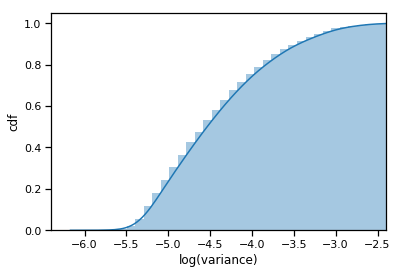

In [21]:
s = sns.distplot(np.log10(var), hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
s.set_ylabel('cdf')
s.set_xlabel('log(variance)')
s.set_xlim(-6.4,-2.4)

#### RF

Run random forest regressor and obtain the gini importance or mean decrease impurity, which is the total reduction in impurity (or error) in nodes averaged over all trees in the ensemble. Higher feature importance means it's more important for classifying the label correctly.

In general, we have to be careful with interpreting the feature importance because this is biased toward variables with more categories (not an issue here since the features are binary-coded) and correlated features can artificially boost or decrease the importance of other correlated variables (summarized from this [source](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)).

Similar to the previous example, we have to make a choice on the total number of features we want to keep or on the minimum threshold value of feature importance. This is also pretty slow.

In [22]:
rfr = RandomForestRegressor(max_depth=5, n_estimators=10)
rfr.fit(X_train_tfidf_pd, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

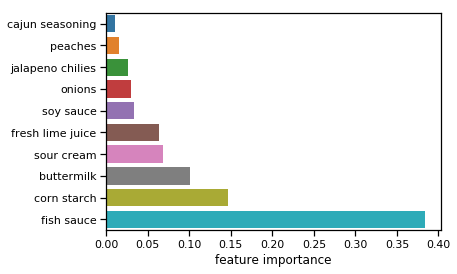

In [ ]:
feat_imp = rfr.feature_importances_
feat_imp_ind = np.argsort(feat_imp)[-10:]
s = sns.barplot(x=feat_imp[feat_imp_ind], y=ingredient_names[feat_imp_ind])
dummy = s.set_xlabel('feature importance')

#### PCA

We will use PCA to create new features that are linear combinations of the existing features. It's fast, so it works well with large number of features. In our case, even PCA isn't very effective at reducing the number of features, as we would still need about 1/3 the number of original features to explain 90% of the variations. For the sake of edification, let's proceed with these 2000 components.

In [ ]:
pca = PCA(n_components=2000)
X_train_pca = pca.fit_transform(X_train_tfidf_pd.values)
X_train_pca_pd = pd.DataFrame(X_train_pca)

In [ ]:
s = sns.barplot(x=np.arange(20)+1, y=pca.explained_variance_ratio_[:20]*100)
s.set_ylabel('explained variance [%]')
s.set_xlabel('PCA component')

print(np.cumsum(pca.explained_variance_ratio_)[-1])

## Now onto predicting the cuisine.

Let's test the following algorithms:

* **Complement Naive Bayes**, a slightly modified version of the Naive Bayes algorithm for multinomially distributed data (multiple classes). According to the documentation, this works better than the standard multinomial Naive Bayes algorithm when we have imbalanced data sets. One relevant hyperparameter is $\alpha$, a smoothing term that appears in the estimation of distribution parameters. NOTE: we cannot use NB with the PCA-transformed data because it requires non-negative data. Running this with the original data yields about 77% accuracy, a good benchmark value to keep in the back of our head.
* **Logistic Regression**
* **Support Vector Machine**
* **Gradient Boosting** is an example of boosting, which is an ensemble method that incrementally improves an initially weak model (e.g., 1 level-deep decision tree, a.k.a. "decision stump") by modeling the residual in each step. We're using sklearn.GBC here but another popular option is XGBoost.


First we want to test the baseline performance of the algorithms.

In [ ]:
algorithms = {'LR':LogisticRegression(), 'SVC':SVC(), \
              'GBC': GradientBoostingClassifier()}
name_list = algorithms.keys()
for i_n, n in enumerate(name_list):
    X_train_0, X_test_0, y_train_0, y_test_0 = model_selection.train_test_split(X_train_pca_pd, y_train, test_size=0.25)
    clf = algorithms[n]
    clf = clf.fit(X_train_0, y_train_0)
    y_pred_0 = clf.predict(X_test_0)
    print(n, "Accuracy: {:.2f}".format(metrics.accuracy_score(y_test_0, y_pred_0)))
          

### Optimize the hyperparameters for the algorithm with the best baseline performance.
We will turn again to hyperopt to automatically fine-tune the hyperparameters and see if we can improve the performance of the classifier.

In [ ]:
def objective(hparams):
    
    #do - becauase this number is minimized
    clf = XXX(**hparams)
    cv_score = model_selection.cross_val_score(clf, X_train_pca_pd, y_train, cv=5, scoring='accuracy')
    loss = -np.mean(cv_score)

    #so we can monitor the progress!
    pbar.update()

    return {'loss': loss, 'hparams': hparams, 'status': STATUS_OK}    

## Future work

The distribution of cuisines shows that the classes are imbalanced (e.g., many times more italian cuisine than irish cuisine). Oversampling?